In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Sequential, load_model,Model
import numpy as np
from tensorflow.keras.losses import categorical_crossentropy as cce
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical

import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn import metrics


In [2]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')

In [28]:
new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])
    new_right_images.append(img)
    new_right_labels.append([1,0])
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)

split = int(0.2*95)

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_trainA = np.concatenate((right_img_shuff[:95],left_img_shuff[:95]),axis =0)
Y_trainA = np.concatenate((left_label_shuff[:split],right_label_shuff[split:95],right_label_shuff[:split],left_label_shuff[split:95]),axis = 0)
X_trainB = np.concatenate((right_img_shuff[95:-1],left_img_shuff[95:-1]),axis =0)
Y_trainB = np.concatenate((left_label_shuff[:split],right_label_shuff[split:95],right_label_shuff[:split],left_label_shuff[split:95]),axis = 0)


right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)

split = int(0.2*47)

X_testA = np.concatenate((right_img_shuff[:47],left_img_shuff[:47]),axis = 0)
Y_testA = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
correct_testA = np.concatenate((right_label_shuff[47:-1],left_label_shuff[47:-1]),axis = 0)
X_testB = np.concatenate((right_img_shuff[47:-1],left_img_shuff[47:-1]),axis = 0)
Y_testB = np.concatenate((left_label_shuff[:split],right_label_shuff[split:47],right_label_shuff[:split],left_label_shuff[split:47]),axis = 0)
correct_testB = np.concatenate((right_label_shuff[47:-1],left_label_shuff[47:-1]),axis = 0)

X_trainA = X_trainA/X_trainA.max()
X_testA = X_testA/X_testA.max()
X_trainB= X_trainB/X_trainB.max()
X_testB = X_testB/X_testB.max()

X_trainA = np.expand_dims(X_trainA,axis=3)
X_testA = np.expand_dims(X_testA,axis=3)
X_trainB = np.expand_dims(X_trainB,axis=3)
X_testB = np.expand_dims(X_testB,axis=3)

X_trainA, Y_trainA = utils.shuffle(X_trainA, Y_trainA,random_state=0)
X_testA, Y_testA, correct_testA = utils.shuffle(X_testA, Y_testA, correct_testA,random_state=0)
X_trainB,Y_trainB = utils.shuffle(X_trainB, Y_trainB,random_state=0)
X_testB, Y_testB, correct_testB = utils.shuffle(X_testB, Y_testB, correct_testB, random_state=0)

batch_size = 25
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generatorA = train_datagen.flow(X_trainA, y=Y_trainA, batch_size=batch_size,seed=seed)
val_generatorA = test_datagen.flow(X_testA,y=Y_testA,batch_size=batch_size,seed=seed)
train_generatorB = train_datagen.flow(X_trainB, y=Y_trainB, batch_size=batch_size,seed=seed)
val_generatorB = test_datagen.flow(X_testB,y=Y_testB,batch_size=batch_size,seed=seed)

In [5]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3))(input_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2))(down_)
    return down_pool

def final_stack(input1_,factor):
    flat = Flatten()(input1_)
    dense1 = Dense(int(64*factor))(flat)
    act1 = Activation('relu')(dense1)
    drop = Dropout(0.5)(act1)
    dense2 = Dense(2)(drop)
    act2 = Activation('softmax')(dense2)
    return act2


def first_cnn(input_,factor):
    down1 = down(int(32*factor),input_)
    down2 = down(int(32*factor),down1)
    down3 = down(int(64*factor),down2)
    down4 = down(int(64*factor),down3)
    down5 = down(int(64*factor),down4)
    # final = first_final_stack(down5)
    return down5

def complete_model(input_shape,factor):
    input1 = Input(shape=input_shape)
    final1 = first_cnn(input1,factor)
    final = final_stack(final1,factor)
    model = Model(inputs=input1, outputs=final)
    return model

In [6]:
modelA = complete_model((128, 128,1),2)
modelB = complete_model((128,128,1),3)

modelA.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])
modelB.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [7]:
modelA.load_weights('savio_nets/coteach_modelA_20perror_round1_weights_v1.h5')
modelB.load_weights('savio_nets/coteach_modelB_20perror_round1_weights_v1.h5')

In [8]:
predAA = modelA.predict(X_testA[:10])
predBB = modelB.predict(X_testB[:10])
predAB = modelA.predict(X_testB[:10])
predBA = modelB.predict(X_testA[:10])

In [24]:
def binarize_label_stack(label_stack):
    new_label_stack = []
    for a in label_stack:
        new_label_stack.append([(a[0]-a.min())/(a.max()-a.min()),(a[1]-a.min())/(a.max()-a.min())])
    return np.array(new_label_stack)

In [25]:
def binarize_label(a):
    return [(a[0]-a.min())/(a.max()-a.min()),(a[1]-a.min())/(a.max()-a.min())]

In [15]:
binarize_label(predAA)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [16]:
binarize_label(predBA)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [18]:
correct_testA[:10]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [19]:
Y_testA[:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

In [22]:
cce(Y_testA[:10],predAA)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.6118095e+01, 4.5596695e-01, 6.0200873e-06, 5.6150383e-01,
       7.1525596e-07, 8.1255317e-02, 5.6087136e-01, 1.1920929e-07,
       1.1920929e-07, 1.6153524e-02], dtype=float32)>

In [23]:
cce(Y_testA[:10],predBA)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([6.0034561e+00, 8.1523396e-02, 1.1920929e-07, 1.1920929e-07,
       1.1920929e-07, 7.3158070e-03, 3.7235994e-04, 1.1920929e-07,
       1.1920929e-07, 1.1920929e-07], dtype=float32)>

In [9]:
predAA

array([[1.0000000e+00, 3.6518799e-08],
       [6.3383478e-01, 3.6616522e-01],
       [6.0400698e-06, 9.9999392e-01],
       [5.7035071e-01, 4.2964929e-01],
       [9.9999928e-01, 6.9940137e-07],
       [7.8041725e-02, 9.2195827e-01],
       [4.2928848e-01, 5.7071155e-01],
       [3.0834779e-12, 1.0000000e+00],
       [1.0000000e+00, 5.8410325e-08],
       [1.6023748e-02, 9.8397624e-01]], dtype=float32)

In [10]:
predBA

array([[9.97529805e-01, 2.47020042e-03],
       [9.21711087e-01, 7.82888606e-02],
       [1.10046493e-13, 1.00000000e+00],
       [1.00000000e+00, 8.29256204e-25],
       [1.00000000e+00, 2.17720078e-11],
       [7.28911860e-03, 9.92710829e-01],
       [3.72303562e-04, 9.99627709e-01],
       [3.35749630e-14, 1.00000000e+00],
       [1.00000000e+00, 8.61563202e-18],
       [1.90080563e-13, 1.00000000e+00]], dtype=float32)

In [27]:
def new_labels_from_loss(modelA,modelB,XtestA,YtestA,XtestB,YtestB):
    predAA = modelA.predict(XtestA)
    predBB = modelB.predict(XtestB)
    lossAA = cce(YtestA,predAA)
    lossBB = cce(YtestB,predBB)
    predAB = modelA.predict(XtestB)
    predBA = modelB.predict(XtestA)
    lossAB = cce(YtestB,predAB)
    lossBA = cce(YtestA,predBA)
    for idx, lAB in enumerate(lossAB):
        if lAB < lossBB[idx]:
            YtestB[idx] = binarize_label(predAB[idx])
    for idx, lBA in enumerate(lossBA):
        if lBA < lossAA[idx]:
            YtestA[idx] = binarize_label(predBA[idx])
    return YtestA, YtestB

In [29]:
Y_trainA, Y_trainB = new_labels_from_loss(modelA,modelB,X_trainA,Y_trainA,X_trainB,Y_trainB)

In [30]:
Y_testA, Y_testB = new_labels_from_loss(modelA,modelB,X_testA,Y_testA,X_testB,Y_testB)

In [33]:
train_generatorA = train_datagen.flow(X_trainA.repeat(400,axis=0), y=np.array(Y_trainA).repeat(400,axis=0), batch_size=batch_size,seed=seed)
val_generatorA = test_datagen.flow(X_testA.repeat(400,axis=0),y=Y_testA.repeat(400,axis=0),batch_size=batch_size,seed=seed)
train_generatorB = train_datagen.flow(X_trainB.repeat(400,axis=0), y=Y_trainB.repeat(400,axis=0), batch_size=batch_size,seed=seed)
val_generatorB = test_datagen.flow(X_testB.repeat(400,axis=0),y=Y_testB.repeat(400,axis=0),batch_size=batch_size,seed=seed)

In [64]:
historyA = modelA.fit_generator(
        train_generatorA,
        steps_per_epoch=2500,
        epochs=2,
        validation_data=val_generatorA,
        validation_steps=100,
        verbose = 0)
historyB = modelB.fit_generator(
        train_generatorB,
        steps_per_epoch=2500,
        epochs=2,
        validation_data=val_generatorB,
        validation_steps=100,
        verbose = 0)

In [65]:
X_val = np.concatenate((new_right_images[286:],new_left_images[286:]),axis = 0)
Y_val = np.concatenate((new_right_labels[286:],new_left_labels[286:]),axis = 0)
X_val = X_val/X_val.max()
X_val = np.expand_dims(X_val,axis=3)
X_val, Y_val = utils.shuffle(X_val, Y_val,random_state=0)
print(modelA.evaluate(X_val,Y_val),modelB.evaluate(X_val,Y_val))

7/7 [==============================] - 1s 164ms/step - loss: 3.0488 - accuracy: 0.7680
[1.060799479484558, 0.8195876479148865] [3.048786163330078, 0.7680412530899048]


In [102]:
predAA = modelA.predict(X_testA[10:20])
predBB = modelB.predict(X_testB[10:20])
predAB = modelA.predict(X_testB[10:20])
predBA = modelB.predict(X_testA[10:20])

In [103]:
binarize_label_stack(predAA)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [104]:
Y_testA[10:20]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [105]:
binarize_label_stack(predBA)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [106]:
correct_testA[10:20]

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

In [44]:
predAA

array([[3.3712651e-19, 1.0000000e+00],
       [9.9999249e-01, 7.5079361e-06],
       [4.9091926e-09, 1.0000000e+00],
       [3.3281555e-07, 9.9999964e-01],
       [3.6769162e-15, 1.0000000e+00],
       [2.0375728e-06, 9.9999797e-01],
       [9.9818461e-02, 9.0018153e-01],
       [6.5484094e-03, 9.9345160e-01],
       [3.4760337e-04, 9.9965239e-01],
       [9.9999344e-01, 6.5497129e-06]], dtype=float32)

In [45]:
predBA

array([[9.8348886e-01, 1.6511189e-02],
       [1.3943300e-06, 9.9999857e-01],
       [2.0781491e-04, 9.9979216e-01],
       [9.9990785e-01, 9.2181901e-05],
       [1.6566629e-10, 1.0000000e+00],
       [2.0816040e-08, 1.0000000e+00],
       [9.9999046e-01, 9.5133291e-06],
       [3.8139169e-05, 9.9996185e-01],
       [2.4024142e-02, 9.7597581e-01],
       [1.6198659e-01, 8.3801341e-01]], dtype=float32)

In [46]:
cce(Y_testA[10:20],predAA)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.1920929e-07, 1.1799550e+01, 1.1920929e-07, 3.5762793e-07,
       1.1920929e-07, 2.0265600e-06, 1.0515883e-01, 5.0285330e+00,
       3.4767471e-04, 6.5565323e-06], dtype=float32)>

In [47]:
cce(Y_testA[10:20],predBA)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([4.1037169e+00, 1.3709077e-06, 2.0786299e-04, 9.2917471e+00,
       1.1920929e-07, 1.1920929e-07, 1.1562817e+01, 1.0174269e+01,
       2.4317415e-02, 1.8202417e+00], dtype=float32)>

In [56]:
Y_testA[10:20]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [57]:
binarize_label_stack(predBA)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [50]:
correct_testA[10:20]

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

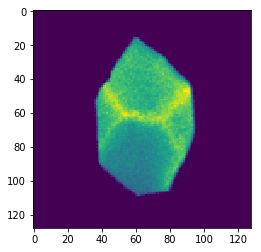

In [52]:
plt.imshow(X_testA[11,:,:,0])

In [53]:
binarize_label_stack(predBA)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [58]:
metrics.accuracy_score(Y_testA[0],binarize_label(predAA[0]))

0.0

In [59]:
Y_testA[0]

array([1, 0])

In [60]:
predAA[0]

array([3.371265e-19, 1.000000e+00], dtype=float32)

In [61]:
metrics.accuracy_score(Y_testA[0],binarize_label(predBA[0]))

1.0

In [62]:
predBA[0]

array([0.98348886, 0.01651119], dtype=float32)

In [90]:
cce([0,1],[0,.999]).numpy()

1.1920929e-07

In [92]:
cce([0,1],[.999,.001]).numpy()

6.9077554

In [83]:
prob = np.arange(0,1,0.01)

In [84]:
bce_bad = -(np.log(1-prob))

In [85]:
bce_good = -(np.log(prob))

/Users/cgroschner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


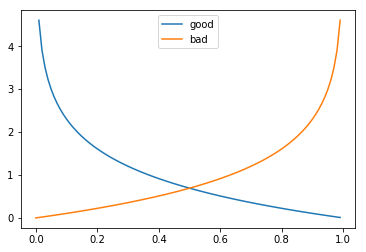

In [89]:
plt.plot(prob,bce_good,label='good')
plt.plot(prob,bce_bad,label='bad')
plt.legend()

In [95]:
def decide_new_label(predAA,predBA,current_label):
    matchAA = metrics.accuracy_score(current_label,binarize_label(predAA))
    matchBA = metrics.accuracy_score(current_label,binarize_label(predBA))
    CAA = predAA.max()
    CBA = predBA.max()
    difC = np.abs(CAA - CBA)
    LAA = cce(current_label,predAA).numpy()
    LAB = cce(current_label,predBA).numpy()
    new = current_label
    if matchAA == 1 and matchBA == 1:
        new = current_label
    elif matchAA == 0 and matchBA == 0:
        new = binarize_label(predBA)
    elif matchAA == 1 and matchBA == 0:
        if CBA > CAA and CBA > 0.6:
            new = binarize_label(predBA)
        elif CBA > CAA and CBA < 0.6:
            new = current_label
        elif CBA < CAA and difC < 0.05 and CBA > 0.85:
            new = binarize_label(predBA)
        elif CBA < CAA and difC < 0.05 and CBA < 0.85:
            new = current_label
    elif matchAA == 0 and matchBA == 1:
        if CAA > CBA and CAA > 0.6:
            new = binarize_label(predAA)
        elif CAA > CBA and CAA < 0.6:
            new = current_label
        elif CAA < CBA and difC < 0.05 and CAA > 0.85:
            new = binarize_label(predAA)
        elif CAA < CBA and difC < 0.05 and CAA < 0.85:
            new = current_label
    return new

In [97]:
predAA

array([[3.3712651e-19, 1.0000000e+00],
       [9.9999249e-01, 7.5079361e-06],
       [4.9091926e-09, 1.0000000e+00],
       [3.3281555e-07, 9.9999964e-01],
       [3.6769162e-15, 1.0000000e+00],
       [2.0375728e-06, 9.9999797e-01],
       [9.9818461e-02, 9.0018153e-01],
       [6.5484094e-03, 9.9345160e-01],
       [3.4760337e-04, 9.9965239e-01],
       [9.9999344e-01, 6.5497129e-06]], dtype=float32)

In [98]:
predBA

array([[9.8348886e-01, 1.6511189e-02],
       [1.3943300e-06, 9.9999857e-01],
       [2.0781491e-04, 9.9979216e-01],
       [9.9990785e-01, 9.2181901e-05],
       [1.6566629e-10, 1.0000000e+00],
       [2.0816040e-08, 1.0000000e+00],
       [9.9999046e-01, 9.5133291e-06],
       [3.8139169e-05, 9.9996185e-01],
       [2.4024142e-02, 9.7597581e-01],
       [1.6198659e-01, 8.3801341e-01]], dtype=float32)

In [99]:
Y_testA[10:20]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [117]:
decide_new_label(predAA[5],predBA[5],Y_testA[15])

array([0, 1])

In [118]:
correct_testA[15]

array([0, 1])